In [1]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [2]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Kanawha/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

In [3]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/geojson/kanawha-basin.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/geojson/kanawha-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [4]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


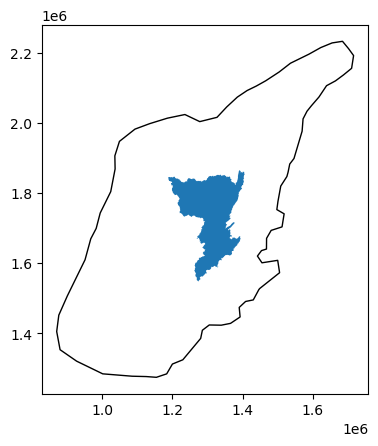

In [5]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [6]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx        1.187435e+06
miny        1.548200e+06
maxx        1.405844e+06
maxy        1.864701e+06
x           1.308114e+06
y           1.738215e+06
range_x     2.184096e+05
range_y     3.165012e+05
area_km2    5.084142e+04
Name: 0, dtype: float64 minx        8.700718e+05
miny        1.274827e+06
maxx        1.716061e+06
maxy        2.232237e+06
x           1.249180e+06
y           1.709628e+06
range_x     8.459895e+05
range_y     9.574101e+05
area_km2    6.211256e+05
Name: 0, dtype: float64


In [7]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [14]:
# Set simulation parameters
lam = 10                   # average number of storms per year
n_full = 10000             # number of years to simulate
n_part = 1000

# Run the simulations
df_full_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_full, method = 'uniform')
df_full_monte = get_return_period(df_full_monte)

df_part_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'uniform')
df_part_monte = get_return_period(df_part_monte)

df_part_is = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'truncnorm',dist_x = dist_x, dist_y = dist_y)
df_part_is = get_return_period(df_part_is)

100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


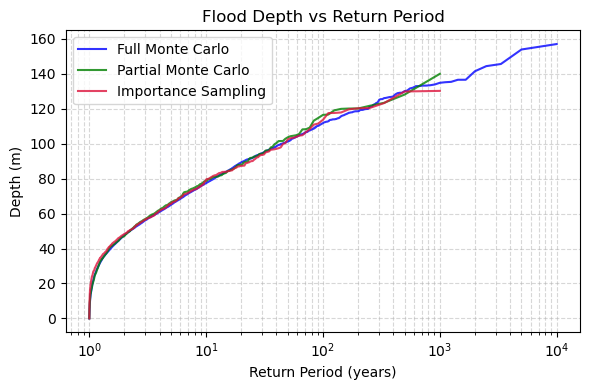

In [15]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_full_monte['return_period'], df_full_monte['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_part_monte['return_period'], df_part_monte['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_part_is['return_period'], df_part_is['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (m)')
plt.title('Flood Depth vs Return Period')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

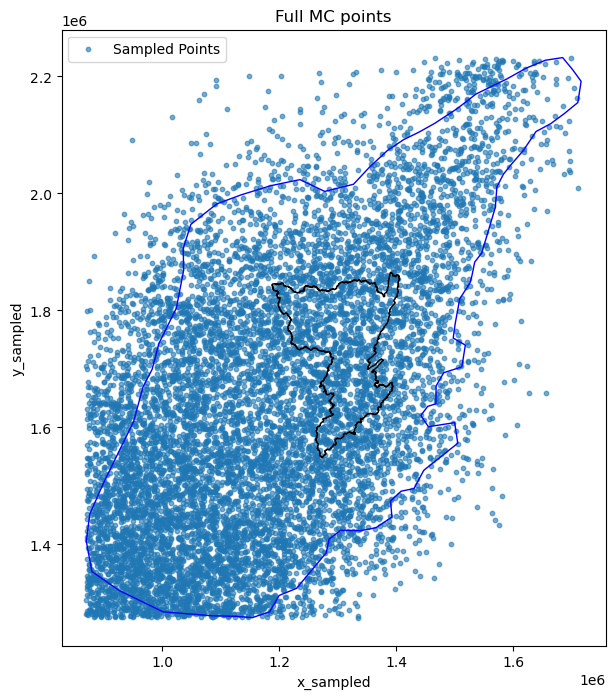

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
df_full_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Full MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

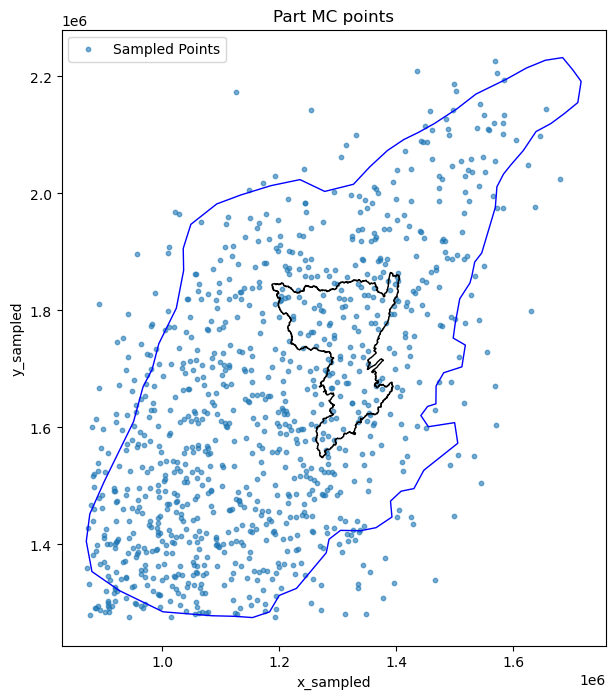

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Part MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

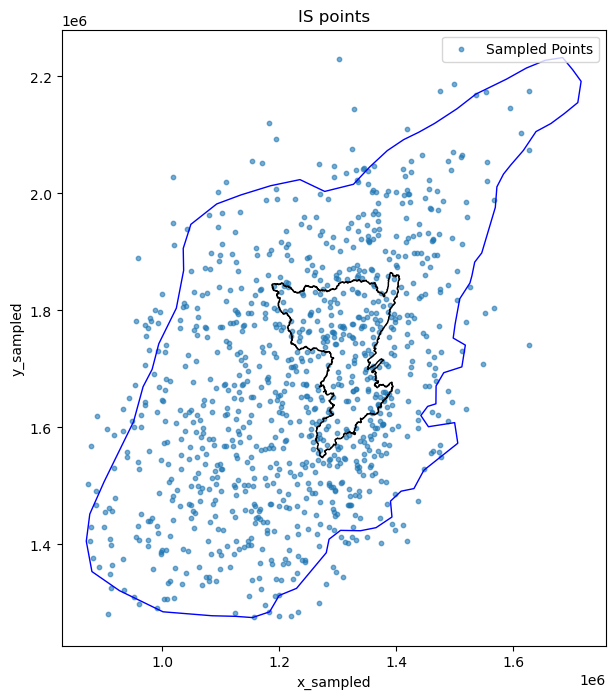

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_is.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

In [20]:
df_part_is

,name,path,x,y,x_sampled,y_sampled,weight,prob,x_del,y_del,depth,intersected,prob_exceed,return_period
0,20200519_Y001_T004,/workspaces/Importance-Sampling-for-SST/data/0...,1.236464e+06,1.655092e+06,1.285603e+06,1.505226e+06,0.581602,0.087099,49138.676435,-149865.577020,130.262039,1,0.000999,1001.000000
1,19901011_Y001_T008,/workspaces/Importance-Sampling-for-SST/data/0...,1.360503e+06,1.732498e+06,1.461151e+06,1.626714e+06,0.600079,0.074686,100648.652900,-105783.826565,129.911423,1,0.001998,500.500000
2,20110904_Y001_T002,/workspaces/Importance-Sampling-for-SST/data/0...,1.233414e+06,1.689953e+06,1.015854e+06,1.476133e+06,1.521812,0.099955,-217559.754703,-213819.548706,123.271027,1,0.002997,333.666667
3,20060625_Y001_T010,/workspaces/Importance-Sampling-for-SST/data/0...,1.374311e+06,1.769129e+06,1.474112e+06,1.836747e+06,0.618196,0.048809,99800.366865,67618.114938,120.427910,1,0.003996,250.250000
4,20060625_Y001_T010,/workspaces/Importance-Sampling-for-SST/data/0...,1.374311e+06,1.769129e+06,1.474036e+06,1.832282e+06,0.615386,0.093674,99724.770471,63152.693746,120.292717,1,0.004995,200.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,19971024_Y002_T067,/workspaces/Importance-Sampling-for-SST/data/0...,1.190478e+06,1.571631e+06,1.399983e+06,2.001822e+06,0.681865,0.114927,209505.681276,430191.643864,10.841971,1,0.995005,1.005020
996,19990107_Y010_T404,/workspaces/Importance-Sampling-for-SST/data/0...,1.196926e+06,1.726360e+06,1.595069e+06,2.145248e+06,2.391218,0.568080,398142.870481,418887.777358,8.678103,1,0.996004,1.004012
997,20180908_Y002_T035,/workspaces/Importance-Sampling-for-SST/data/0...,1.287069e+06,1.835990e+06,1.284389e+06,1.428876e+06,0.715551,0.129732,-2679.708770,-407113.908583,6.729529,1,0.997003,1.003006
998,20120930_Y003_T213,/workspaces/Importance-Sampling-for-SST/data/0...,1.188718e+06,1.562844e+06,1.382222e+06,1.506979e+06,0.610316,0.050683,193504.000424,-55864.955701,6.175366,1,0.998002,1.002002
